# Clustering

In [8]:
!pip install plotly

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
import plotly.offline as offline

np.random.seed(42)

#### Métodos utilitarios

In [10]:
def plot_explained_variance_ratio(dim_to_plot):
    pca = PCA(n_components=dim_to_plot, whiten=True)
    pca.fit(data)
    explained_variance_ratio = pca.explained_variance_ratio_
    dims = range(dim_to_plot)

    plt.plot(range(1, dim_to_plot + 1), explained_variance_ratio)
    plt.xticks(dims)

    vrSum = 0
    minPercentage = 11
    addlegend = True
    for nc, vr in zip(dims, explained_variance_ratio):
        vrSum += vr
        if (vrSum * 100 > minPercentage and [1,2,3,5,7,10,15].count(nc + 1) > 0):
            label = "{:.2%} ({})".format(vrSum, nc + 1)
            plt.annotate(label, # this is the text
                        (nc + 1,vr), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(35, 0), # distance from text to points (x,y)
                        ha='center')
            if (addlegend):
                plt.scatter(nc + 1, vr, c='r', label='Varianza acumulada')
                addlegend = False
            else:
                plt.scatter(nc + 1, vr, c='r')
            minPercentage += 11

    plt.title('Reducción de la dimensión')
    plt.xlabel('Número de componentes')
    plt.ylabel('Porcentaje de varianza')
    plt.legend(loc="upper right")
    plt.axvline(7, color='red', linestyle='--', linewidth=1, alpha=1)
    plt.show()

In [11]:
def plot_dendrogram(model, distance_threshold, **kwargs):
    plt.figure(figsize=(40,10))
    plt.title("Hierarchical Clustering Dendrogram")

    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode=None, leaf_font_size=14, color_threshold=distance_threshold, **kwargs)
    plt.axhline(distance_threshold, color='black', linestyle='-', linewidth=1, alpha=1)
    plt.show()

In [12]:
def plot_elbow_method(clusters, distortions, optimal):
    plt.plot(clusters, distortions, 'bo-')
    plt.xticks(clusters)
    plt.xlabel('Número de clusters')
    plt.ylabel('Distorción')
    plt.title('Selección clusters - método del codo')
    plt.axvline(optimal, color='red', linestyle='--', linewidth=1, alpha=1)
    plt.show()

In [13]:
def plot_3d(data, targets, title):
    labels = np.unique(targets)
    data_to_plot = []
    for label in labels:
        data_label = data[targets==label]
        trace = go.Scatter3d(
            x = data_label[:,0],
            y = data_label[:,1],
            z = data_label[:,2],
            mode = 'markers',
            name = str(label),
            marker = dict(size = 5)
        )
        data_to_plot.append(trace)

    layout = go.Layout(
        width=700,
        height=600,
        title = title,
        scene = dict(
                xaxis = dict(title = 'comp 0'),
                yaxis = dict(title = 'comp 1'),
                zaxis = dict(title = 'comp 2')
            )
    )

    fig = go.Figure(data=data_to_plot, layout=layout)
    offline.iplot(fig)

## Data - Targets

In [14]:
raw_targets = pd.read_csv('datasets/clase.txt', sep=',')

# Limpiando la data de Targets
targets = np.array(raw_targets.iloc[:,1])

print('Tejidos:', np.unique(targets))

Tejidos: ['cerebellum' 'colon' 'endometrium' 'hippocampus' 'kidney' 'liver'
 'placenta']


## Data - Samples

In [15]:
raw_data = pd.read_csv('datasets/dataset_tissue.txt', sep=',')
pd.DataFrame(raw_data).head()

,Unnamed: 0,GSM11805.CEL.gz,GSM11814.CEL.gz,GSM11823.CEL.gz,GSM11830.CEL.gz,GSM12067.CEL.gz,GSM12075.CEL.gz,GSM12079.CEL.gz,GSM12098.CEL.gz,GSM12105.CEL.gz,...,GSM323527.CEL.gz,GSM323565.CEL.gz,GSM323566.CEL.gz,GSM323567.CEL.gz,GSM246492.CEL.gz,GSM246493.CEL.gz,GSM246494.CEL.gz,GSM307639.CEL.gz,GSM307640.CEL.gz,GSM307641.CEL.gz
0,1007_s_at,10.191267,10.509167,10.272027,10.252952,10.157605,9.966782,9.839348,9.945652,9.913031,...,11.797743,10.040886,11.285002,9.888693,9.661127,9.803686,10.509541,9.984502,9.937738,10.306781
1,1053_at,6.040463,6.696075,6.144663,6.575153,6.606701,6.060069,6.186596,5.927861,6.337478,...,6.157979,6.224848,6.170956,6.211522,6.270153,6.058488,6.345526,6.715984,6.836179,7.025547
2,117_at,7.447409,7.775354,7.696235,8.478135,8.116336,7.644452,8.009581,7.847192,7.983850,...,7.727192,7.573437,7.323547,7.228568,7.333568,7.486711,7.468406,7.120793,7.125811,7.407624
3,121_at,12.025042,12.007817,11.633279,11.075286,10.832528,11.705062,11.706145,11.750370,10.706184,...,10.443504,10.566722,10.250737,10.191332,9.703713,9.914632,9.909784,9.409933,9.587782,9.792904
4,1255_g_at,5.269269,5.180389,5.301714,5.372235,5.334905,5.253682,5.228794,5.155278,5.236442,...,5.263736,5.048867,5.062005,5.186962,5.158631,5.312712,5.341193,4.896124,5.296695,5.206251


#### Normalizando la data

In [16]:
# Ajustando la data para su procesamiento
data = np.array(raw_data.iloc[:,1:]).T

# Normalizando la data
data = preprocessing.normalize(data)

print('Data ajustado y normalizada, shape:', data.shape)
pd.DataFrame(data).head()

Data ajustado y normalizada, shape: (189, 22215)


,0,1,2,3,4,5,6,7,8,9,...,22205,22206,22207,22208,22209,22210,22211,22212,22213,22214
0,0.008959,0.005310,0.006547,0.010571,0.004632,0.007503,0.006085,0.005027,0.007105,0.004777,...,0.007128,0.004616,0.006241,0.007218,0.006801,0.005657,0.005011,0.008098,0.007331,0.006477
1,0.009236,0.005885,0.006833,0.010553,0.004553,0.007547,0.006119,0.004918,0.006651,0.004642,...,0.007095,0.004754,0.006069,0.007314,0.007200,0.006747,0.005771,0.008275,0.007219,0.006959
2,0.009067,0.005424,0.006793,0.010268,0.004680,0.007306,0.006227,0.004923,0.006299,0.004663,...,0.006893,0.004676,0.005930,0.007418,0.007028,0.005671,0.004979,0.007232,0.007464,0.006707
3,0.009007,0.005776,0.007448,0.009730,0.004720,0.007559,0.006251,0.005149,0.007560,0.004722,...,0.007060,0.005294,0.005901,0.007729,0.007314,0.005583,0.005056,0.007487,0.007519,0.006852
4,0.008949,0.005821,0.007151,0.009544,0.004700,0.007316,0.006237,0.005047,0.007900,0.004832,...,0.007230,0.004945,0.005799,0.007558,0.007105,0.005672,0.005334,0.007023,0.007420,0.006644


## Redución de dimensión utilizando Principal Component Analysis

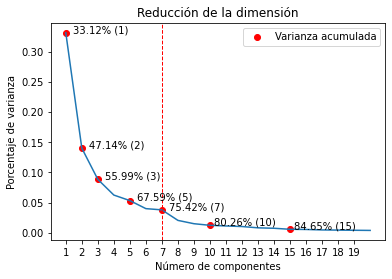

In [17]:
# Ploteando el procentaje de varianza de 1 a 20 de componentes
plot_explained_variance_ratio(dim_to_plot=20)

# Reduciendo la dimensionalidad de la data
dim_reduced = 7
data_reduced = PCA(n_components=dim_reduced, whiten=True).fit_transform(data)

#### Data reducida

In [37]:
print('Data reducida, shape:', data_reduced.shape)
pd.DataFrame(data_reduced)

Data reducida, shape: (189, 7)


,0,1,2,3,4,5,6
0,-0.553677,-0.676291,1.641158,0.133679,0.891150,-0.292006,-1.121255
1,-0.688195,-0.919342,1.173049,-0.064599,0.434606,-0.036350,-0.224672
2,-0.688801,0.112706,1.159383,-0.011977,2.000643,-0.044693,-1.909550
3,-0.665106,-0.223302,1.008195,0.175019,1.561074,0.518926,-0.260476
4,-0.600599,-0.481172,1.432586,0.223119,1.141321,0.268561,-0.572235
...,...,...,...,...,...,...,...
184,-0.412392,-1.313760,0.245709,-0.785470,-2.366863,3.797869,-2.098254
185,-0.658449,-1.139725,-0.305686,-0.714935,-2.008820,4.384100,-1.576880
186,-0.728159,-0.914028,-0.350815,-0.655957,-1.968228,4.730323,-1.731435
187,-0.756124,-0.628891,-0.673335,-0.558619,-1.467763,4.884330,-1.321957


In [19]:
plot_3d(data_reduced, targets, 'Clusters originales de Tejidos')


## Análisis cantidad de clusters - Método del codo

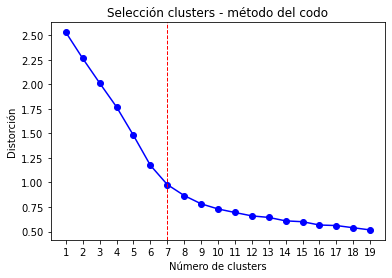

In [20]:
from sklearn.cluster import KMeans

clusters = range(1,20)
distortions = []
for c in clusters:
    kmeanModel = KMeans(init="k-means++", n_clusters=c, n_init=10, random_state=0)
    kmeanModel.fit(data_reduced)
    # Distortion: It is calculated as the average of the squared distances
    # from the cluster centers of the respective clusters. Typically, the
    # Euclidean distance metric is used.
    distortions.append(sum(np.min(cdist(data_reduced, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_reduced.shape[0])

plot_elbow_method(clusters, distortions, 7)


## Agglomerative Hierarchical Clustering

Número de clusters: 7


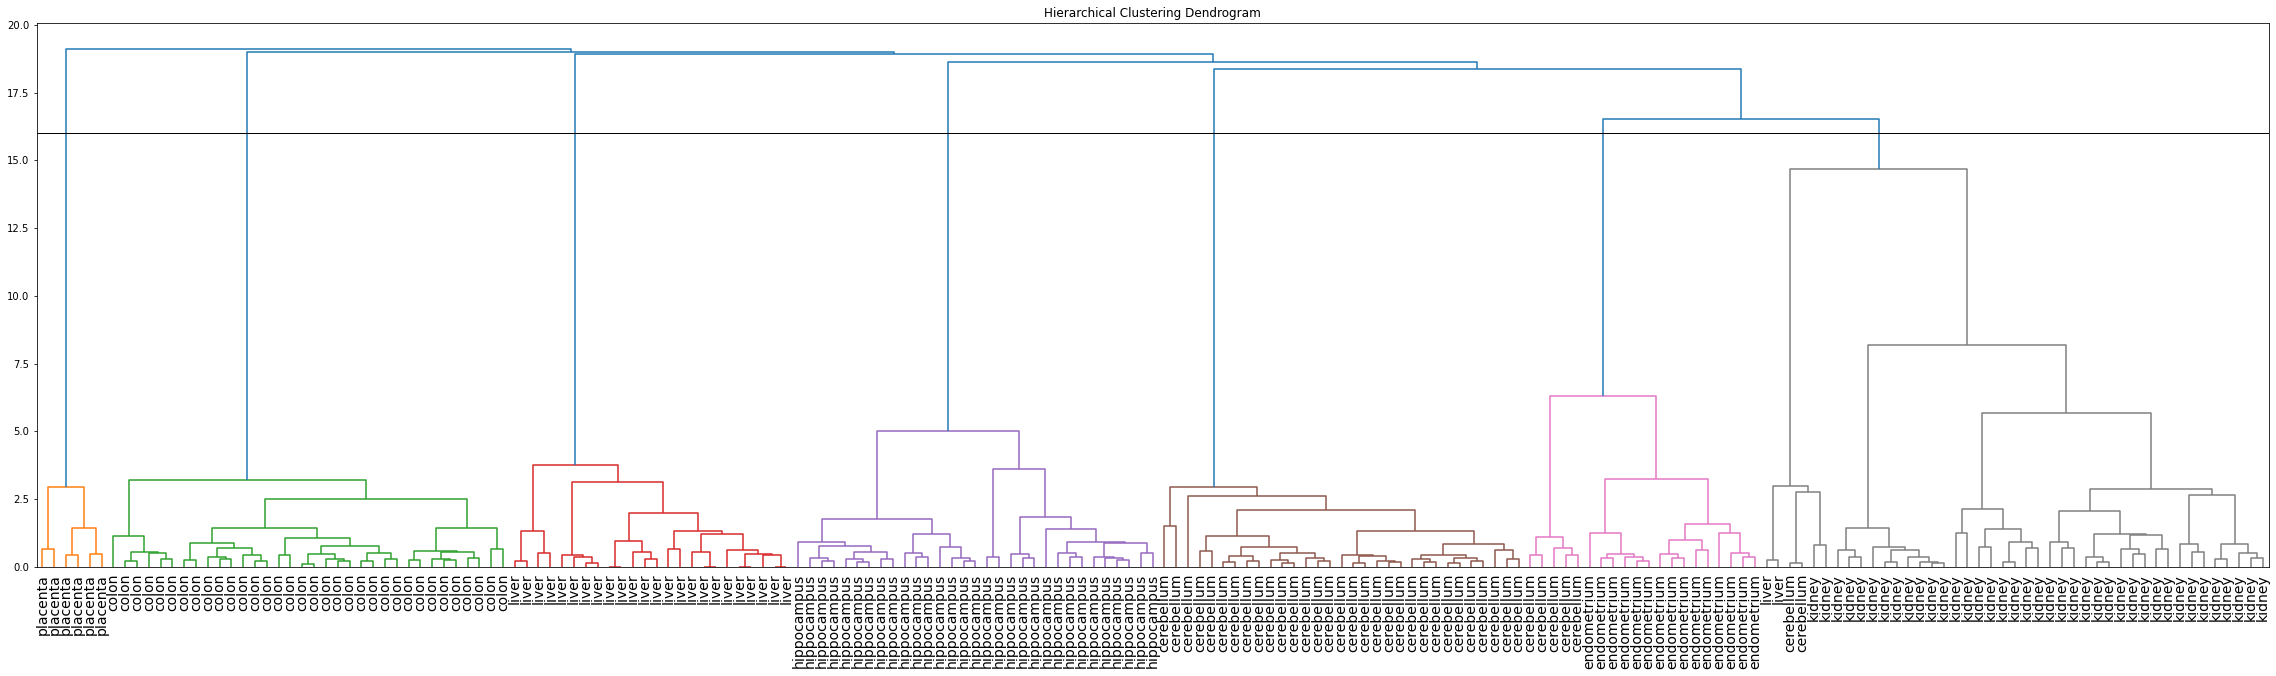

In [21]:
# Agglomerative Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
distance_threshold=16
model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None)
model = model.fit(data_reduced)
print('Número de clusters:', model.n_clusters_)

# Ploteando el dendrograma que ilustra cómo está compuesto cada cluster
plot_dendrogram(model, distance_threshold, labels=targets)

In [22]:
y_pred = model.fit_predict(data_reduced)
pd.crosstab(targets, y_pred, rownames=['target'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,4,5,6,All
target,,,,,,,,
cerebellum,2,0,5,0,0,31,0,38
colon,0,0,0,0,0,0,34,34
endometrium,0,0,15,0,0,0,0,15
hippocampus,0,31,0,0,0,0,0,31
kidney,39,0,0,0,0,0,0,39
liver,2,0,0,0,24,0,0,26
placenta,0,0,0,6,0,0,0,6
All,43,31,20,6,24,31,34,189


In [23]:
plot_3d(data_reduced, y_pred, 'Clusters con Agglomerative Hierarchical Clustering')

## Hiperparámetros

In [24]:
n_clusters = 7

## K-Means

In [25]:
# KMeans - implementación propia
from kmeans import Kmeans

kmeansModel = Kmeans(data_reduced, n_clusters, n_iterations=10, seed=456523)
kmeansModel.fit()
kmeans_pred = np.array(kmeansModel.idx_centroid_assigned)

pd.crosstab(targets, kmeans_pred, rownames=['target'], colnames=['cluster'], margins=True)

Break on interation: 5


cluster,0,1,2,3,4,5,6,All
target,,,,,,,,
cerebellum,5,0,0,0,33,0,0,38
colon,0,34,0,0,0,0,0,34
endometrium,15,0,0,0,0,0,0,15
hippocampus,0,0,0,0,0,31,0,31
kidney,0,0,39,0,0,0,0,39
liver,0,0,0,26,0,0,0,26
placenta,0,0,0,0,0,0,6,6
All,20,34,39,26,33,31,6,189


In [26]:
# KMeans - implementación de sklearn
from sklearn.cluster import KMeans

skModel = KMeans(init="random", n_clusters=n_clusters, n_init=10, random_state=42).fit(data_reduced)

pd.crosstab(targets, skModel.labels_, rownames=['target'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,4,5,6,All
target,,,,,,,,
cerebellum,0,0,0,31,2,5,0,38
colon,0,0,0,0,0,0,34,34
endometrium,0,0,0,0,0,15,0,15
hippocampus,0,0,31,0,0,0,0,31
kidney,0,0,0,0,26,13,0,39
liver,0,24,0,0,2,0,0,26
placenta,6,0,0,0,0,0,0,6
All,6,24,31,31,30,33,34,189


In [27]:
plot_3d(data_reduced, kmeans_pred, 'Clusters con K-Means')

## Gaussian Mixture Model

In [28]:
# Gaussian Mixture Model - implementación propia
from gmm import GMM

GMM = GMM(data_reduced, n_clusters, n_iterations=10, seed=0)
GMM.run()

data_predicted = [np.array(GMM.predict(data_reduced[i])).argmax(axis=0) for i in range(len(data_reduced))]

pd.crosstab(targets, np.array(data_predicted), rownames=['target'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,4,5,6,All
target,,,,,,,,
cerebellum,0,0,0,30,3,5,0,38
colon,0,0,32,0,0,2,0,34
endometrium,0,0,0,0,4,11,0,15
hippocampus,0,25,0,0,0,4,2,31
kidney,17,0,0,2,14,0,6,39
liver,9,15,0,2,0,0,0,26
placenta,0,0,6,0,0,0,0,6
All,26,40,38,34,21,22,8,189


In [29]:
# Gaussian Mixture Model - implementación de sklearn
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(data_reduced)
gmm_predic = gm.predict(data_reduced)

pd.crosstab(targets, gmm_predic, rownames=['target'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,4,5,6,All
target,,,,,,,,
cerebellum,0,0,33,0,0,0,5,38
colon,0,34,0,0,0,0,0,34
endometrium,0,0,0,0,0,0,15,15
hippocampus,0,0,0,31,0,0,0,31
kidney,0,0,0,0,39,0,0,39
liver,26,0,0,0,0,0,0,26
placenta,0,0,0,0,0,6,0,6
All,26,34,33,31,39,6,20,189


In [30]:
plot_3d(data_reduced, gmm_predic, 'Clusters con Gaussian Mixture Model')

## DBSCAN

In [31]:
from sklearn.cluster import DBSCAN
from itertools import product

# Experimentaciones para obtener el eps y samples óptimos
eps_values = np.round(np.arange(0.6, 1.6, 0.05),2) # eps a evaluar
min_samples = np.arange(4, 10) # samples a evaluar
params = list(product(eps_values, min_samples))

results = []
results_labels_ = []
for p in params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit(data_reduced)
    results.append(np.array([p[0], p[1]]))
    results_labels_.append(dbscan.labels_)
results = np.array(results)

optimal_result_idx = 0
min_noise = list(results_labels_[0]).count(-1)
for i, r in enumerate(results):
    noise = list(results_labels_[i]).count(-1)
    dbscan_clusters = len(np.unique(results_labels_[i])) - 1
    if noise < min_noise and dbscan_clusters == n_clusters:
        min_noise = noise
        optimal_result_idx = i

optimal_eps = results[optimal_result_idx][0]
optimal_samples = results[optimal_result_idx][1]

print('eps óptimo:', optimal_eps)
print('samples óptimo:', optimal_samples)
print('número de puntos de ruido:', min_noise)

eps óptimo: 1.5
samples óptimo: 4.0
número de puntos de ruido: 6


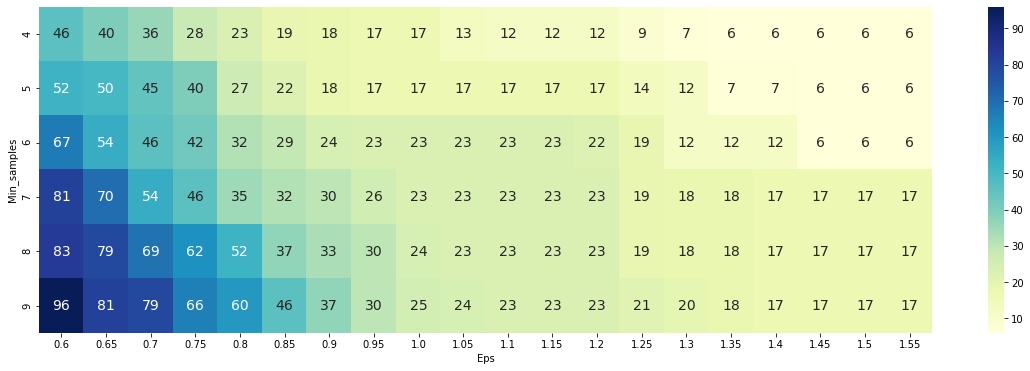

In [32]:
import seaborn as sns
tmp = pd.DataFrame.from_records(params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = [list(i).count(-1) for i in results_labels_]

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(20,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 14}, cmap="YlGnBu", ax=ax)
plt.show()

In [33]:
# DBSCAN - implementación de sklearn
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_samples).fit(data_reduced)

pd.crosstab(targets, dbscan.labels_, rownames=['target'], colnames=['cluster'], margins=True)

cluster,-1,0,1,2,3,4,5,6,All
target,,,,,,,,,
cerebellum,2,0,0,36,0,0,0,0,38
colon,0,0,0,0,34,0,0,0,34
endometrium,0,0,0,0,0,0,15,0,15
hippocampus,0,0,31,0,0,0,0,0,31
kidney,2,37,0,0,0,0,0,0,39
liver,2,0,0,0,0,24,0,0,26
placenta,0,0,0,0,0,0,0,6,6
All,6,37,31,36,34,24,15,6,189


In [34]:
plot_3d(data_reduced, dbscan.labels_, 'Clusters con DBSCAN')